In [3]:
# Load gemini
#from context import gemini
from gemini  import data, engine, helpers

# Global Imports
import pandas as pd
import numpy as np

# Build mean reversion strategy
#from talib.abstract import *
import talib
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [20, 12]
%matplotlib inline

from peakdetect import peakdet
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
from scipy import spatial
from scipy.stats import norm

In [6]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.layouts import column
output_notebook()

Loading BokehJS ...

In [7]:
#Finding MACD and adding to df
def add_macd(df):
    output = talib.MACD(df['close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
    df['macd'] = output[0]
    df['macdsignal'] = output[1]
    df['macdhist'] = output[2]
    return df


In [8]:
#EMA of price for smoothing the curve
def add_ema(df):
    ema_close = df['close'].ewm(span=5,min_periods=0,adjust=False,ignore_na=False).mean() #talib.EMA(df['close'].values,10)
    #ema_close = df['close']
    df['ema']=ema_close
    return df

In [9]:
#finding extremas in macd
def extrema_macd(df, smoothing_factor=1):
    maxtab_macd, mintab_macd = peakdet(df['macdhist'].values,smoothing_factor)
#print(maxtab_macd)
#maxtab = argrelextrema(df['macd'].values, np.greater)
#print((maxtab_macd))

#print(maxtab_macd[0][10])
    df['maxima_macd']= False
    df['minima_macd']=False
    for i in range(len(maxtab_macd)):
        if(df['maxima_macd'].loc[maxtab_macd[i][0]]== False):
            df['maxima_macd'].loc[maxtab_macd[i][0]]= True 
        
    for i in range(len(mintab_macd)):
        if(df['minima_macd'].loc[mintab_macd[i][0]]== False):
            df['minima_macd'].loc[mintab_macd[i][0]]= True 

    return df, maxtab_macd, mintab_macd



In [10]:
#Plotting the extermas
def plot_exterma(df,values, mintab,maxtab,y_axis):
    # create a new plot with a title and axis labels
    p = figure(title=y_axis, x_axis_label='Index', y_axis_label=y_axis, plot_width=1000, plot_height=400)

    # add a line renderer with legend and line thickness
    p.line(df.index,values, legend='value', line_width=0.6)
    p.scatter(np.array(maxtab)[:,0],np.array(maxtab)[:,1],
          fill_color='red', fill_alpha=1,
          line_color=None)
    p.scatter(np.array(mintab)[:,0],np.array(mintab)[:,1],
          fill_color='green', fill_alpha=1,
          line_color=None)
    show(p)

In [193]:
#plot_exterma(df,df['macd'], mintab_macd,maxtab_macd, 'MACD')

In [11]:
#Finding peaks/lows in Prices (scipy aggrelmin and aggrelmax can also be used)
def extrema_price(df, smoothing_factor=1):
    
    maxtab_close, mintab_close = peakdet(df['ema'],smoothing_factor)
    
    #print(maxtab_macd[0][10])
    df['maxima_close']= False
    df['minima_close']=False
    for i in range(1,len(maxtab_close)):
        if(df['maxima_close'].loc[maxtab_close[i][0]]== False):
            df['maxima_close'].loc[maxtab_close[i][0]]= True 
        
    for i in range(1,len(mintab_close)):
        if(df['minima_close'].loc[mintab_close[i][0]]== False):
            df['minima_close'].loc[mintab_close[i][0]]= True 
        

    return df, maxtab_close, mintab_close




In [12]:
#Helper Function to Update the divergence presence in df
def update_df_signal(df, divergence_list):
    list_len=len(divergence_list)
    for i in range(list_len):
        for j in range(int(divergence_list[i][0]), int(divergence_list[i][1])):
            if(df['signal'].loc[j]!=1):
                df['signal'].loc[j]=divergence_list[i][2]
        df['signal_start_end'].loc[int(divergence_list[i][0])]=1 #Start
        df['signal_start_end'].loc[int(divergence_list[i][1])]=2 #End
        
    return df
    

In [13]:
def normal_distribution(signals):
    std = np.std(signals)
    mean = np.mean(signals)
    normal_dist= norm(mean,std)
    
    signal_strength=[]
    for i in range(0,len(signals)):
        signal_strength.append(normal_dist.cdf(signals[i]))
    
    return signal_strength

In [14]:
#Function to calculate Signal Strength
def signal_strength_cosine(df, divergence_list):
    #Step 1 Convert signal to Vectors
    vector_macd = []
    vector_price = []
    
    for i in range(0,len(divergence_list)):
        y_macd = df['macdhist'].loc[divergence_list[i][1]] - df['macdhist'].loc[divergence_list[i][0]]
        x_macd = divergence_list[i][1] - divergence_list[i][0]
        vector_macd.append([x_macd,y_macd])
        x_price = divergence_list[i][1] - divergence_list[i][0]
        y_price = df['close'].loc[divergence_list[i][1]] - df['close'].loc[divergence_list[i][0]]
        vector_price.append([x_price,y_price])
    
    signal_cosine = []
    for i in range(0, len(vector_macd)):
        quality = spatial.distance.cosine(vector_macd[i],vector_price[i])
        signal_cosine.append(quality)
    
    signal_strength=normal_distribution(signal_cosine)
    
    signal = pd.DataFrame()
    divergence_list=np.array(divergence_list)
    signal['start']=divergence_list[:,0]
    signal['end'] = divergence_list[:,1]
    signal['type']= divergence_list[:,2]
    signal['strength']=signal_strength
    return signal
    

In [15]:
# Code to return the Gradient Sum of MACD and Price in presence of Divergence
def signal_strength_rlt_gradient(df, divergence_list):
    #Step 1 Convert signal to Vectors
    vector_macd = []
    vector_price = []
    
    for i in range(0,len(divergence_list)):
        y_macd = abs(df['macdhist'].loc[divergence_list[i][1]] - df['macdhist'].loc[divergence_list[i][0]])#/df['macd'].loc[divergence_list[i][1]]
        x_macd = divergence_list[i][1] - divergence_list[i][0]
        vector_macd.append([x_macd,y_macd])
        x_price = divergence_list[i][1] - divergence_list[i][0]
        y_price = abs(df['close'].loc[divergence_list[i][1]] - df['close'].loc[divergence_list[i][0]])#/df['close'].loc[divergence_list[i][1]]
        vector_price.append([x_price,y_price])
    
    signal_quality = []
    for i in range(0, len(vector_macd)):
        quality = (y_macd+y_price)/(2*x_macd)
        signal_quality.append(quality)
    return signal_quality
    

In [16]:
# Code to Merge consecutive Divergences 
def merge(divergence_list):
    divergence_merge = []
    n = len(divergence_list)
    i=0
    while i < n-1:
        start=  divergence_list[i][0]
        while i< n-1 and  divergence_list[i][1] == divergence_list[i+1][0] and divergence_list[i][2]==divergence_list[i+1][2]:
            i+=1
        end = divergence_list[i][1]
        div_type = divergence_list[i][2]
        divergence_merge.append([start, end, div_type])
        i+=1
            
    return divergence_merge

In [17]:
def check_minima_interpolation(start, end, start_value, end_value, minmax_list):
    for i in range(len(minmax_list)):
        return 0
    

In [18]:
def add_crossover(df, divergence_list):
    for i in range(len(divergence_list)):

        j = int(divergence_list[i][1])
        if (df['macdhist'].loc[j]>0):
            #print(divergence_list[i])
            while (df['macdhist'].loc[j] > 0 ):
                j+=1
            df['crossover'].loc[j]=1
        elif(df['macdhist'].loc[j]<0):
            #print(divergence_list[i])
            while (df['macdhist'].loc[j] < 0 ):
                j+=1
            df['crossover'].loc[j]=1

In [19]:
#Function to Calculate Divergence
def divergence(df,maxtab_close, mintab_close, maxtab_macd, mintab_macd):
    
    divergence = []
    #Interpolated version for Price Maxima and Minima 
    f_close_mintab = interp1d(mintab_close[:,0] ,mintab_close[:,1],fill_value="extrapolate")
    f_close_maxtab = interp1d(maxtab_close[:,0] ,maxtab_close[:,1],fill_value="extrapolate")
    
    #Divergence Bull Signal 
    for i in range(1,len(mintab_macd)-2):
        #print(mintab_macd[i,0])
        #Bull Signal -- MACD Minimas going UP, Prices Minimas going DOWN
        if (mintab_macd[i,1] < mintab_macd[i+1,1]):  
            # Checking the Interpolation Function if the MACDsignal Minima is increasing/decreasing
            if(f_close_mintab(mintab_macd[i,0]) > f_close_mintab(mintab_macd[i+1,0])):
                #check_minima_interpolation(mintab_macd[i,0],mintab_macd[i+1,0],f_close_mintab(mintab_macd[i,0]),f_close_mintab(mintab_macd[i+1,0]), mintab_close)
                divergence.append([mintab_macd[i,0],mintab_macd[i+1,0],1])
        
        #Hidden Bull Signal  -- MACD Minima's going DOWN, and Price Minima's going UP
        if (mintab_macd[i,1] > mintab_macd[i+1,1]):  
                if(f_close_mintab(mintab_macd[i,0]) < f_close_mintab(mintab_macd[i+1,0])):
                    divergence.append([mintab_macd[i,0],mintab_macd[i+1,0],2])
                    
    #Divergence Bear Signal 
    for i in range(len(maxtab_macd)-2):
        #Bear Signal - MACD maximas going DOWN and Price Maxima's going UP
        if (maxtab_macd[i,1] > maxtab_macd[i+1,1]):  
            if(f_close_maxtab(maxtab_macd[i,0]) < f_close_maxtab(maxtab_macd[i+1,0])):
                divergence.append([maxtab_macd[i,0],maxtab_macd[i+1,0],3])
        #Hidden Bear Signal -- MACD Maxima going UP and Price Maxima's going DOWN
        if (maxtab_macd[i,1] < maxtab_macd[i+1,1]):  
            if(f_close_maxtab(maxtab_macd[i,0]) > f_close_maxtab(maxtab_macd[i+1,0])):
                divergence.append([maxtab_macd[i,0],maxtab_macd[i+1,0],4])
    
    divergence = merge(divergence)
    df['signal']=0
    df['signal_start_end']=0
    df = update_df_signal(df,divergence)
    df['crossover']=0
    df = add_crossover(df, divergence)
    return df,divergence
                
    

In [28]:
#Function to Calculate Divergence
def divergence_price(df,maxtab_close, mintab_close, maxtab_macd, mintab_macd):
    
    divergence = []
    #Interpolated version for Price Maxima and Minima 
    f_macd_mintab = interp1d(mintab_macd[:,0] ,mintab_macd[:,1],fill_value="extrapolate")
    f_macd_maxtab = interp1d(maxtab_macd[:,0] ,maxtab_macd[:,1],fill_value="extrapolate")
    
    #Divergence Bull Signal 
    for i in range(1,len(mintab_close)-2):
        #print(mintab_macd[i,0])
        #Bull Signal -- MACD Minimas going UP, Prices Minimas going DOWN
        if (mintab_close[i,1] > mintab_close[i+1,1]):  
            # Checking the Interpolation Function if the MACDsignal Minima is increasing/decreasing
            if(f_macd_mintab(mintab_close[i,0]) < f_macd_mintab(mintab_close[i+1,0])):
                divergence.append([mintab_close[i,0],mintab_close[i+1,0],1])
        
        #Hidden Bull Signal  -- MACD Minima's going DOWN, and Price Minima's going UP
        if (mintab_close[i,1] < mintab_close[i+1,1]):  
                if(f_macd_mintab(mintab_close[i,0]) > f_macd_mintab(mintab_close[i+1,0])):
                    divergence.append([mintab_close[i,0],mintab_close[i+1,0],2])
                    
    #Divergence Bear Signal 
    for i in range(len(maxtab_close)-2):
        #Bear Signal - MACD maximas going DOWN and Price Maxima's going UP
        if (maxtab_close[i,1] < maxtab_close[i+1,1]):  
            if(f_macd_maxtab(maxtab_close[i,0]) > f_macd_maxtab(maxtab_close[i+1,0])):
                divergence.append([maxtab_close[i,0],maxtab_close[i+1,0],3])
        #Hidden Bear Signal -- MACD Maxima going UP and Price Maxima's going DOWN
        if (maxtab_close[i,1] > maxtab_close[i+1,1]):  
            if(f_macd_maxtab(maxtab_close[i,0]) > f_macd_maxtab(maxtab_close[i+1,0])):
                divergence.append([maxtab_close[i,0],maxtab_close[i+1,0],4])
    
    divergence = merge(divergence)
    df['signal']=0
    df['signal_start_end']=0
    df['add_crossover']=0
    df = update_df_signal(df,divergence)
    #df = add_crossover(df, divergence)
    return df,divergence

In [21]:
# create a new plot with a title and axis labels
def plot_divergence(df, maxtab_close, mintab_close,maxtab_macd, mintab_macd, title):
    title = title.replace('"','')
    title = title.replace(',','')
    title = title.replace(' ','-')
    
    p1 = figure(title=title, x_axis_label="index", y_axis_label='Price', plot_width=1000, plot_height=400)

# add a line renderer with legend and line thickness
    p1.line(df.index,df['ema'], legend="EMA-5-Close", line_width=0.6, line_color='black')
    p1.scatter(df.where(df['signal'] == 1).index, df.where(df['signal'] == 1)['ema'],
          fill_color='green', fill_alpha=1,legend='bull',
          line_color=None)
    p1.scatter(df.where(df['signal'] == 2).index, df.where(df['signal'] == 2)['ema'],
          fill_color='blue', fill_alpha=1,legend='hidden bull',
          line_color=None)
    p1.scatter(df.where(df['signal'] == 3).index, df.where(df['signal'] == 3)['ema'],
          fill_color='#A53434', fill_alpha=1,legend='bear',
          line_color=None)
    p1.scatter(df.where(df['signal'] == 4).index, df.where(df['signal'] == 4)['ema'],
          fill_color='#FFD900', fill_alpha=1,legend='hidden bear',
          line_color=None)
    
    # create a new plot with a title and axis labels  
    p2 = figure(title=title, x_axis_label='Index', y_axis_label='MACD Hist', plot_width=1000, plot_height=200)

    # add a line renderer with legend and line thickness
    p2.line(df.index,df['macdhist'], legend="MACD Histogram", line_width=0.6,line_color='black')
    p2.scatter(np.array(maxtab_macd)[:,0],np.array(maxtab_macd)[:,1],
          fill_color='red', fill_alpha=1,
          line_color=None)
    p2.scatter(np.array(mintab_macd)[:,0],np.array(mintab_macd)[:,1],
          fill_color='green', fill_alpha=1,
          line_color=None)
    
    p3 = figure(title="MACD (12, 26, close, 9)", x_axis_label='index', plot_width=1000, plot_height=400, toolbar_location=None, x_range=p1.x_range)
    p3.quad(top=df.macdhist[1:], bottom=0, left=df.index[:-1], right=df.index[1:], alpha=0.5)

    output_file(title+".html")
    show(column(p1,p2, p3))

In [22]:
#For Simple Backtesting Accuracy of Divergence Signal 
def backtesting_walkforward(df,signal, look_forward):
    pct_price_change = []
    pct_interpolation_change = []
    #confusion_list=[]
    TP = 0
    FN = 0
    TN = 0
    FP = 0
    for i in range(0,len(signal)):
        price_change=df['close'].loc[int(signal['end'].loc[i])+look_forward] - df['close'].loc[int(signal['end'].loc[i])]
        pct_price_change.append((price_change*100)/(df['close'].loc[int(signal['end'].loc[i])+10]))
        if signal['type'].loc[i]==1 or signal['type'].loc[i]==2:
            if(price_change > 0):
                TP += 1
            elif(price_change < 0):
                FN += 1
        elif signal['type'].loc[i]==3 or signal['type'].loc[i]==4:
            if(price_change < 0):
                TN += 1
            elif(price_change > 0):
                FP += 1
    signal['price_change']=pct_price_change
    #signal['confusion']=confusion_list
    
    accuracy = performance(TP, FP, TN, FN)
    return signal, accuracy

In [23]:
#Different Performance Parameters from Confusion Matrix
def performance(TP, FP, TN, FN):
    
    accuracy = {}
    if(TP+FP+TN+FN ==0):
        return 0
    # Sensitivity, hit rate, recall, or true positive rate
    accuracy['TPR'] = TP/(TP+FN)
    # Specificity or true negative rate
    accuracy['TNR'] = TN/(TN+FP) 
    # Precision or positive predictive value
    accuracy['PPV'] = TP/(TP+FP)
    # Negative predictive value
    accuracy['NPV'] = TN/(TN+FN)
    # Fall out or false positive rate
    accuracy['FPR'] = FP/(FP+TN)
    # False negative rate
    accuracy['FNR'] = FN/(TP+FN)
    # False discovery rate
    accuracy['FDR'] = FP/(TP+FP)

    # Overall accuracy
    accuracy['ACC'] = (TP+TN)/(TP+FP+FN+TN)
    #print(accuracy)
    return accuracy
    

In [24]:
# Higher timeframes (>= daily) Run this program for finding any analysis

df = data.get_htf_candles("BTC_USD", "Bitfinex", "1-DAY", "2017-02-01 00:00:00", "2019-02-01 00:00:00")
#df.head()

In [615]:
# Lower timeframes (< daily)
#df = data.get_ltf_candles("USDT_BTC", "60-MIN", "2018-1-01 00:00:00", "2018-01-07 00:00:00")

In [25]:
#All helpers functions 
df = add_macd(df)
df = add_ema(df)
df, maxtab_macd, mintab_macd = extrema_macd(df,smoothing_factor=15)
df, maxtab_close, mintab_close = extrema_price(df, smoothing_factor=150) 
#Convert smoothing factor to % basis instead of normal
#df.tail()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [26]:
#Extremas plotting
plot_exterma(df,df['macdhist'], mintab_macd,maxtab_macd,'MACD Histogram')
plot_exterma(df,df['ema'], mintab_close,maxtab_close,'Price')

In [29]:
#Calculation of divergence
df, divergence_list = divergence_price(df,maxtab_close, mintab_close, maxtab_macd, mintab_macd)
#dt.tail()

In [30]:
#Plotting of divergence
plot_divergence(df,maxtab_close, mintab_close, maxtab_macd, mintab_macd, '"BTC_USD", "Bitfinex", "1-DAY", "2017-01-01 00:00:00", "2019-02-01 00:00:00')

In [31]:
signal = signal_strength_cosine(df,divergence_list)
signal, accuracy = backtesting_walkforward(df,signal, look_forward=4)
print(signal)
print(accuracy)

          start          end       type   strength  price_change
0  165.00000000 327.00000000 2.00000000 0.82440294    4.44620358
1  327.00000000 371.00000000 1.00000000 0.83165225    4.37172302
2  410.00000000 429.00000000 1.00000000 0.83039817    2.81894690
3  429.00000000 481.00000000 2.00000000 0.76587293    5.50273771
4  481.00000000 512.00000000 1.00000000 0.82136320   11.47308782
5  620.00000000 683.00000000 1.00000000 0.74011467   23.23214331
6  130.00000000 212.00000000 3.00000000 0.50433209  -12.68726034
7  320.00000000 329.00000000 4.00000000 0.09140432   -9.35406838
8  340.00000000 361.00000000 4.00000000 0.09422331  -34.90226575
9  384.00000000 397.00000000 3.00000000 0.83099973  -26.49454545
10 397.00000000 415.00000000 4.00000000 0.09249623  -16.01803411
11 491.00000000 505.00000000 4.00000000 0.11048373   -7.37987621
12 544.00000000 623.00000000 4.00000000 0.18128909   -2.23223901
{'TPR': 1.0, 'TNR': 1.0, 'PPV': 1.0, 'NPV': 1.0, 'FPR': 0.0, 'FNR': 0.0, 'FDR': 0.0, 'ACC'

In [404]:
#print(df.where(df['signal_start_end']==0))

In [1]:
#BackTesting Trade on Gemini Based on Divergence Signal
def logic(account, lookback):
    try:
        lookback = helpers.period(lookback)
        today = lookback.loc(0)
        long_flag =0
        short_flag =0
        #Selling all short position (if any) and Buying with the capital available
        if (today.signal==1 or today.signal==2):
            exit_price = today.low
            for position in account.positions:
                if position.type == 'short':
                    account.close_position(position, 1, exit_price)
                    print('Short Sold', today.signal, today.signal_start_end)
                    short_flag =0
            if (today.signal==1 and today.signal_start_end == 2) or (today.signal==2 and today.signal_start_end == 1):
                print('long', today.signal, today.signal_start_end)
                risk          = 0.5
                entry_price   = today.low
                entry_capital = account.buying_power*risk
                if entry_capital > 0:
                    account.enter_position('long', entry_capital, entry_price)
                    long_flag =1
        #Selling all long position and Shorting the capital Available
        if (today.signal==3 or today.signal==4):
            exit_price = today.low
            for position in account.positions:
                if position.type == 'long':
                    account.close_position(position, 1, exit_price)
                    print('Long Sold', today.signal, today.signal_start_end)
                    long_flag =0 
            if (today.signal==3 and today.signal_start_end == 2) or (today.signal==4 and today.signal_start_end == 1):
                print('short', today.signal, today.signal_start_end)
                risk          = 0.5
                entry_price   = today.low
                entry_capital = account.buying_power*risk
                if entry_capital > 0:
                    account.enter_position('short', entry_capital, entry_price)
    
    except Exception as e:
        print(e)
        pass # Handles lookback errors in beginning of dataset
        

In [2]:
backtest = engine.backtest(df)
output = backtest.start(1000, logic)
output.tail()

NameError: name 'engine' is not defined

In [608]:
backtest.results()


-------------- Results ----------------

Buy and Hold : -25.3%
Net Profit   : -252.97
Strategy     : 20.95%
Net Profit   : 209.46
Longs        : 6
sells        : 6
shorts       : 4
covers       : 3
--------------------
Total Trades : 19

---------------------------------------


IndexError: invalid index

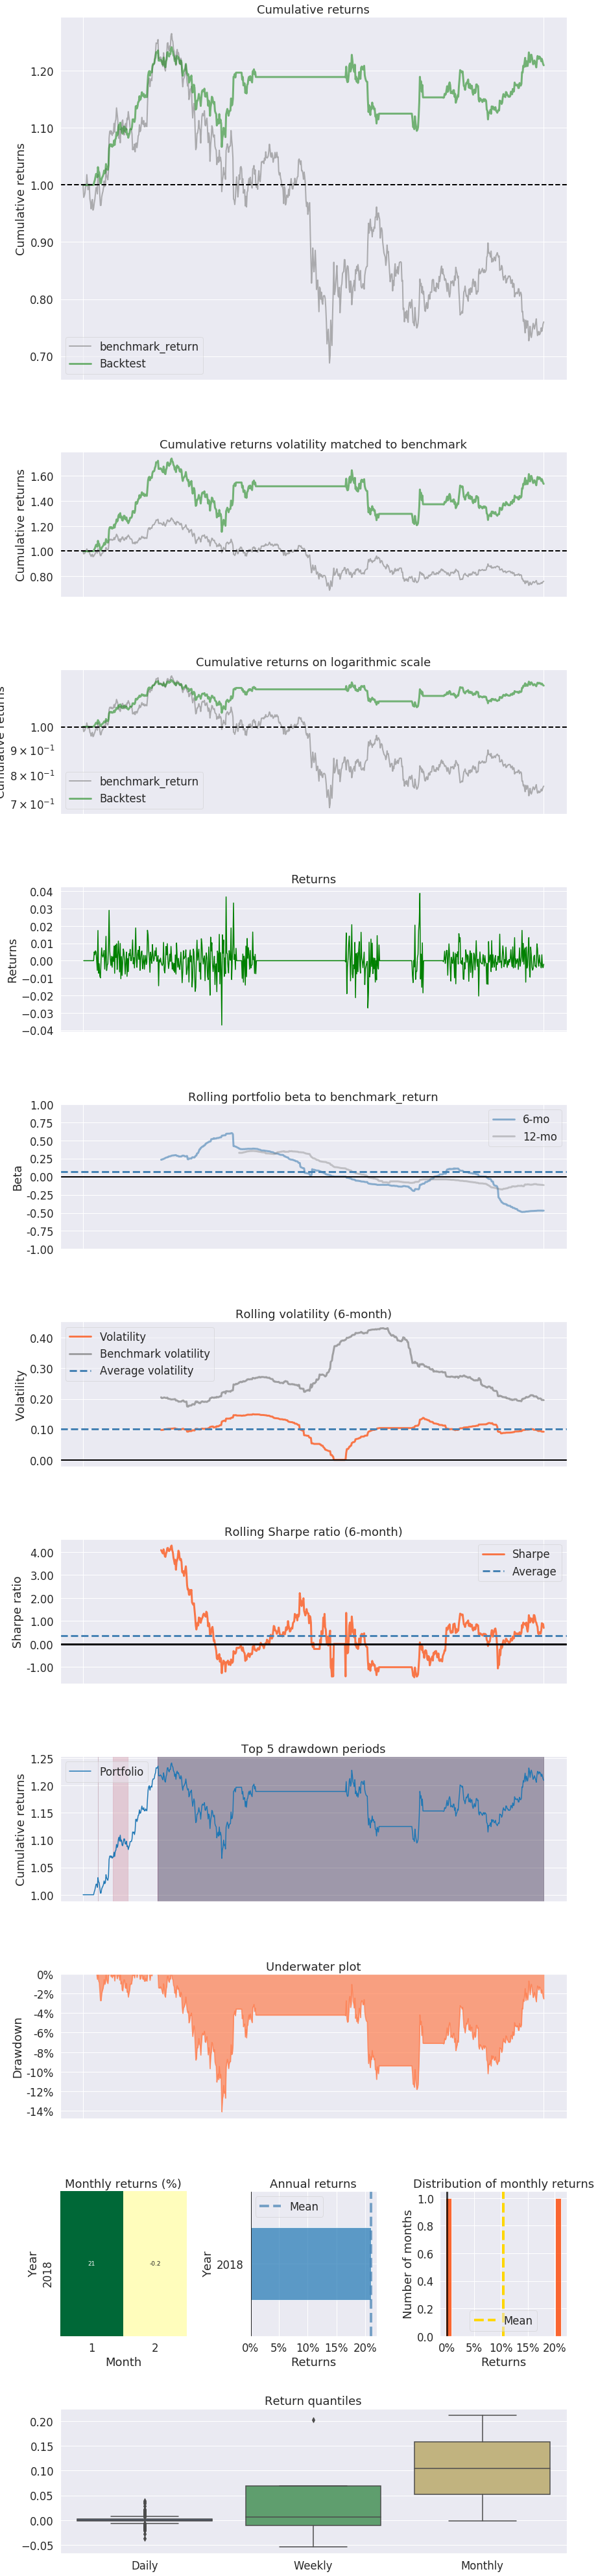

In [609]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

pf.create_returns_tear_sheet(output['strategy_return'], benchmark_rets=output['benchmark_return'])

In [625]:
print(divergence_list)

[[17.0, 60.0, 2]]


In [633]:
# finding completion, after the divergence
for i in range(len(divergence_list)):

    j = int(divergence_list[i][0])
    print(df['macdhist'].loc[j])
    if (df['macdhist'].loc[j]>0):
        print(divergence_list[i])
        while (df['macdhist'].loc[j] > 0 ):
            j+=1
        print(j)
        #print(df['close'].loc[divergence_list[i][1]]- df['close'].loc[j])
        #print(df['close'].loc[j]- df['close'].loc[j+4])
    elif(df['macdhist'].loc[j]<0):
        print(divergence_list[i])
        while (df['macdhist'].loc[j] < 0 ):
            j+=1
        print(j)
        #print(df['close'].loc[divergence_list[i][1]]- df['close'].loc[j])
        #print(df['close'].loc[j]- df['close'].loc[j+4])

nan
